# Getting Data

In [1]:
from setup_and_validation import download_data, validate_data
import polars as pl
import matplotlib.pyplot as plt

In [2]:
URL_DATA = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
df = download_data(URL_DATA)
df.head()


date,state,blood_type,donations
date,str,str,i64
2006-01-01,"""Johor""","""all""",87
2006-01-02,"""Johor""","""all""",15
2006-01-03,"""Johor""","""all""",8
2006-01-04,"""Johor""","""all""",33
2006-01-05,"""Johor""","""all""",20


In [3]:
validate_data(df)

All rows have been validated successfully.
No duplicated rows detected.


In [4]:
print(f"We have {df.height} rows. Let's check the contents.")

We have 459225 rows. Let's check the contents.


In [5]:
print(f"Number of days: {df['date'].n_unique()}")
print(f"Number of blood types: {df['blood_type'].n_unique()}")
print(f"Number of states: {df['state'].n_unique()}")

Number of days: 7065
Number of blood types: 5
Number of states: 13


In [6]:
assert df.height == df['date'].n_unique() * df['blood_type'].n_unique() * df['state'].n_unique()

Now, we could confirm that we have exactly one row per date, state , and blood type combination.

In [7]:
# We have the 'all' column which should be exactly equal to the sum of the four blood types. Let's check this! 

grouped_df = df.filter(pl.col('blood_type') != 'all').group_by(['state', 'date']).agg(pl.col('donations').sum())
df_all = df.filter(pl.col('blood_type') == 'all')
comp_df = df_all.join(grouped_df, on=['date', 'state'], how='inner').with_columns((pl.col('donations') - pl.col('donations_right')).alias('diff'))

diff_df = comp_df.filter(pl.col('diff') != 0)
diff_df

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2021-06-25,"""W.P. Kuala Lumpur""","""all""",436,435,1
2018-03-05,"""W.P. Kuala Lumpur""","""all""",269,268,1
2012-09-09,"""W.P. Kuala Lumpur""","""all""",482,481,1
2014-01-10,"""W.P. Kuala Lumpur""","""all""",151,150,1
2023-10-13,"""Terengganu""","""all""",140,139,1
…,…,…,…,…,…
2009-03-01,"""W.P. Kuala Lumpur""","""all""",993,992,1
2019-01-30,"""W.P. Kuala Lumpur""","""all""",442,441,1
2023-01-20,"""W.P. Kuala Lumpur""","""all""",384,383,1


It seems that 217 rows have mismatches, we can further check how 'severe' these mismatches are.

In [8]:
print(diff_df['diff'].max())
print(diff_df['diff'].min())

3
1


In [9]:
# Differences seem not too bad, but let's check
diff_df.sort('diff', descending=True)

date,state,blood_type,donations,donations_right,diff
date,str,str,i64,i64,i64
2022-09-15,"""W.P. Kuala Lumpur""","""all""",577,574,3
2016-05-17,"""W.P. Kuala Lumpur""","""all""",672,670,2
2013-04-08,"""W.P. Kuala Lumpur""","""all""",315,313,2
2014-06-26,"""W.P. Kuala Lumpur""","""all""",641,639,2
2013-06-08,"""W.P. Kuala Lumpur""","""all""",155,153,2
…,…,…,…,…,…
2009-03-01,"""W.P. Kuala Lumpur""","""all""",993,992,1
2019-01-30,"""W.P. Kuala Lumpur""","""all""",442,441,1
2023-01-20,"""W.P. Kuala Lumpur""","""all""",384,383,1


We see some differences / data issues. However, in the grand scheme of things, the differences are relatively minor and we can just replace the 'all' column with a sum of the other values.

In [10]:
# We regroup this by pivoting the table
df = df.pivot(
    values="donations",
    index=["date", "state"],
    on="blood_type"
).drop('all')
df

date,state,a,b,o,ab
date,str,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3
2006-01-02,"""Johor""",4,3,6,2
2006-01-03,"""Johor""",2,2,4,0
2006-01-04,"""Johor""",7,11,12,3
2006-01-05,"""Johor""",3,8,8,1
…,…,…,…,…,…
2025-05-01,"""W.P. Kuala Lumpur""",371,323,573,60
2025-05-02,"""W.P. Kuala Lumpur""",58,62,103,4
2025-05-03,"""W.P. Kuala Lumpur""",217,212,367,10


In [11]:
df = df.with_columns(pl.sum_horizontal(["a", "b", "o", "ab"]).alias("all"))
df

date,state,a,b,o,ab,all
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3,87
2006-01-02,"""Johor""",4,3,6,2,15
2006-01-03,"""Johor""",2,2,4,0,8
2006-01-04,"""Johor""",7,11,12,3,33
2006-01-05,"""Johor""",3,8,8,1,20
…,…,…,…,…,…,…
2025-05-01,"""W.P. Kuala Lumpur""",371,323,573,60,1327
2025-05-02,"""W.P. Kuala Lumpur""",58,62,103,4,227
2025-05-03,"""W.P. Kuala Lumpur""",217,212,367,10,806


# Visualization

For the time being, we will drop the 'state' column and look at the nationwide level.

In [12]:
df_all = df.group_by(pl.col('date')).sum().drop('state').sort('date')
df_all

date,a,b,o,ab,all
date,i64,i64,i64,i64,i64
2006-01-01,152,139,194,40,525
2006-01-02,53,43,112,19,227
2006-01-03,29,21,56,6,112
2006-01-04,92,98,165,36,391
2006-01-05,149,198,193,42,582
…,…,…,…,…,…
2025-05-01,1021,945,1683,210,3859
2025-05-02,192,231,363,46,832
2025-05-03,523,567,947,84,2121


In [13]:
# For visualization, we group this by week.
# Otherwise, the outcome plots cannot really show the line difference

df_weekly = (
    df_all
    .with_columns(
        [
            pl.col('date').dt.week().alias('week'),
            pl.col('date').dt.year().alias('year')
        ]
    ).group_by(['year', 'week']).sum()
    .sort('year', 'week')
    .drop('date')
    .with_columns(pl.concat_str(pl.col('year'), pl.col('week'), separator = '-')
    .alias('yearweek'))
)

df_weekly

year,week,a,b,o,ab,all,yearweek
i32,i8,i64,i64,i64,i64,i64,str
2006,1,664,678,1013,194,2549,"""2006-1"""
2006,2,747,785,1181,183,2896,"""2006-2"""
2006,3,1322,1439,2138,323,5222,"""2006-3"""
2006,4,954,1038,1475,241,3708,"""2006-4"""
2006,5,416,481,751,118,1766,"""2006-5"""
…,…,…,…,…,…,…,…
2025,15,3021,3206,5140,738,12105,"""2025-15"""
2025,16,3237,3550,5449,798,13034,"""2025-16"""
2025,17,3071,3341,5399,722,12533,"""2025-17"""


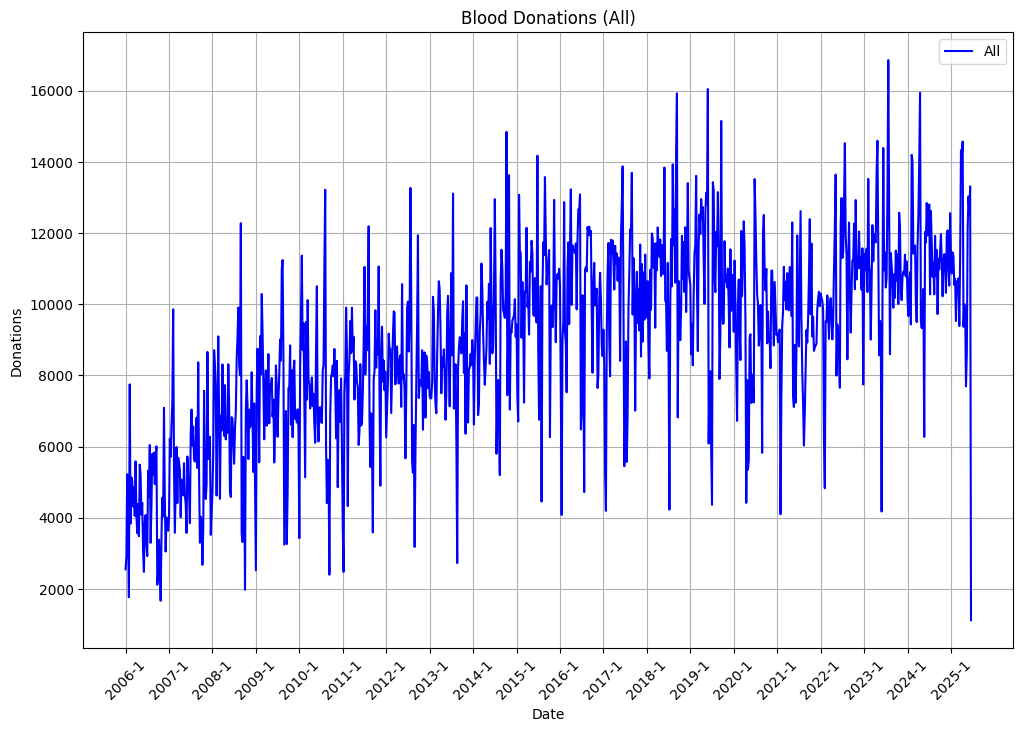

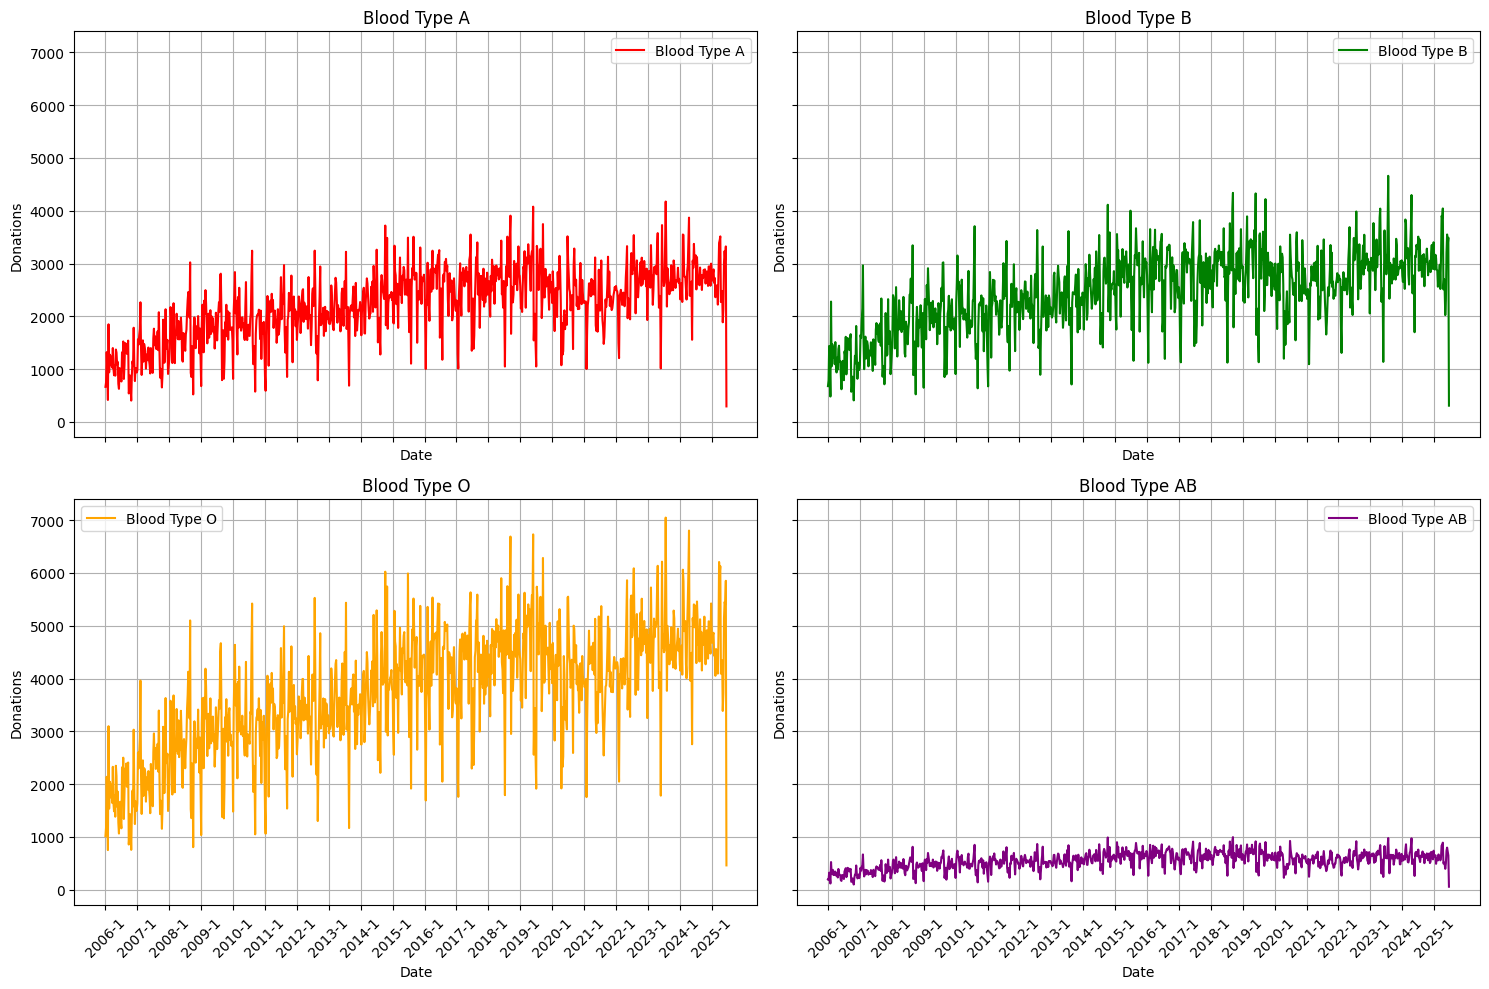

In [14]:
# Plot for the 'all' column
plt.figure(figsize=(12, 8))
plt.plot(df_weekly['yearweek'], df_weekly['all'], label='All', color='blue')
plt.title('Blood Donations (All)')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.grid()

# Set x-axis ticks to the first week of each year
year_ticks = df_weekly.filter(pl.col('week') == 1)['yearweek']
plt.xticks(ticks=range(0, len(df_weekly['yearweek']), 52),  # Approximate yearly interval
           labels=year_ticks, rotation=45)  # Rotate for readability

plt.show()

# 2x2 plot for 'a', 'b', 'o', and 'ab' columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

columns = ['a', 'b', 'o', 'ab']
titles = ['Blood Type A', 'Blood Type B', 'Blood Type O', 'Blood Type AB']
colors = ['red', 'green', 'orange', 'purple']

for i, ax in enumerate(axes.flat):
    ax.plot(df_weekly['yearweek'], df_weekly[columns[i]], label=titles[i], color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Donations')
    ax.legend()
    ax.grid()

    # Set x-axis ticks to the first week of each year
    ax.set_xticks(range(0, len(df_weekly['yearweek']), 52))  # Approximate yearly interval
    ax.set_xticklabels(year_ticks, rotation=45)  # Rotate for readability

plt.tight_layout()
plt.show()

Some interesting facts we can already tell from here: 
- Across all blood types and overall, we see already an increasing trend
- We see some seasonality, some ups and downs
- Blood type O is always highest, whereas AB is always lower (which makes sense given the prevalence)


In [15]:
# Correlation matrices

corr_a_b = []
corr_a_ab = []
corr_a_o = []
corr_b_ab = []
corr_b_o = []
corr_ab_o = []
total_pop = []
states = []


for elem in df['state'].unique():
    total_donations = df.filter(pl.col('state') == elem)['all'].sum()
    print(f"{elem}: {total_donations} total donations.")
    corrmatrix = df.filter(df['state'] == elem).select(['a', 'b', 'o', 'ab']).corr()
    print(corrmatrix)
    
    states.append(elem)
    corr_a_b.append(corrmatrix[0, 1])
    corr_a_ab.append(corrmatrix[0, 2])
    corr_a_o.append(corrmatrix[0, 3])
    corr_b_ab.append(corrmatrix[1, 2])
    corr_b_o.append(corrmatrix[1, 3])
    corr_ab_o.append(corrmatrix[2,3])
    total_pop.append(total_donations)
    
    print("\n")

Pulau Pinang: 448359 total donations.
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.954136 ┆ 0.966424 ┆ 0.899937 │
│ 0.954136 ┆ 1.0      ┆ 0.961949 ┆ 0.903382 │
│ 0.966424 ┆ 0.961949 ┆ 1.0      ┆ 0.903206 │
│ 0.899937 ┆ 0.903382 ┆ 0.903206 ┆ 1.0      │
└──────────┴──────────┴──────────┴──────────┘


Negeri Sembilan: 291346 total donations.
shape: (4, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ a        ┆ b        ┆ o        ┆ ab       │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╡
│ 1.0      ┆ 0.902501 ┆ 0.918179 ┆ 0.769759 │
│ 0.902501 ┆ 1.0      ┆ 0.915262 ┆ 0.782784 │
│ 0.918179 ┆ 0.915262 ┆ 1.0      ┆ 0.779545 │
│ 0.769759 ┆ 0.782784 ┆ 0.779545 ┆ 1.0      │
└──────────┴─────

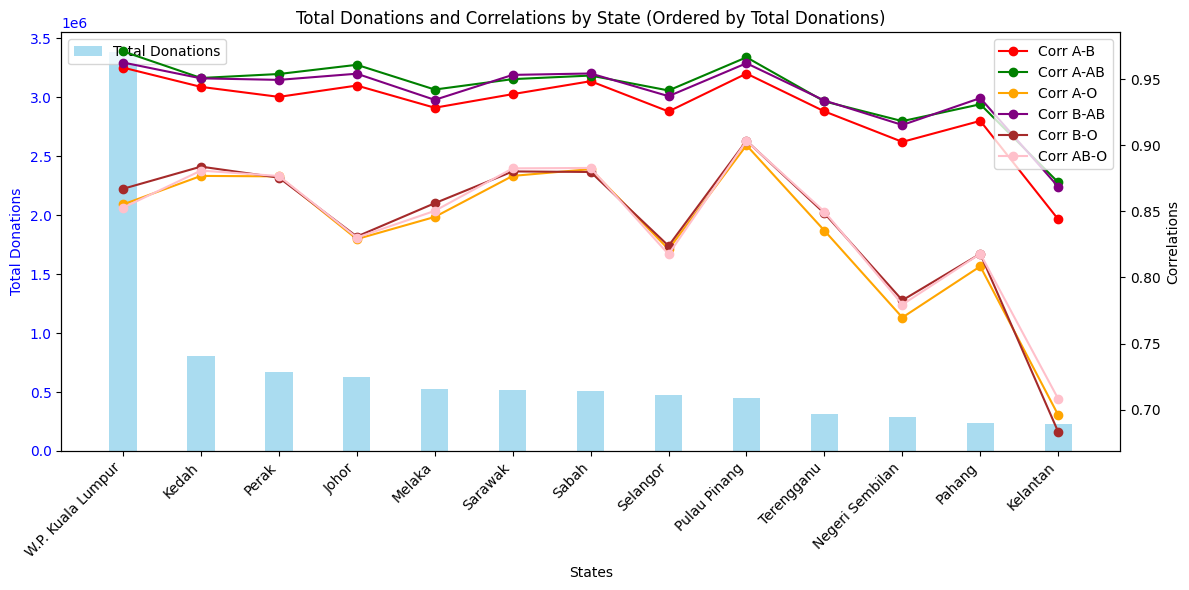

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Sort states and total_pop based on total_pop in descending order
sorted_indices = np.argsort(total_pop)[::-1]
states_sorted = [states[i] for i in sorted_indices]
total_pop_sorted = [total_pop[i] for i in sorted_indices]
corr_a_b_sorted = [corr_a_b[i] for i in sorted_indices]
corr_a_ab_sorted = [corr_a_ab[i] for i in sorted_indices]
corr_a_o_sorted = [corr_a_o[i] for i in sorted_indices]
corr_b_ab_sorted = [corr_b_ab[i] for i in sorted_indices]
corr_b_o_sorted = [corr_b_o[i] for i in sorted_indices]
corr_ab_o_sorted = [corr_ab_o[i] for i in sorted_indices]

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for total donations
bar_width = 0.35
x = np.arange(len(states_sorted))
ax1.bar(x, total_pop_sorted, bar_width, label='Total Donations', color='skyblue', alpha=0.7)
ax1.set_xlabel('States')
ax1.set_ylabel('Total Donations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(states_sorted, rotation=45, ha='right')

# Line plot for correlations
ax2 = ax1.twinx()
ax2.plot(x, corr_a_b_sorted, label='Corr A-B', marker='o', color='red')
ax2.plot(x, corr_a_ab_sorted, label='Corr A-AB', marker='o', color='green')
ax2.plot(x, corr_a_o_sorted, label='Corr A-O', marker='o', color='orange')
ax2.plot(x, corr_b_ab_sorted, label='Corr B-AB', marker='o', color='purple')
ax2.plot(x, corr_b_o_sorted, label='Corr B-O', marker='o', color='brown')
ax2.plot(x, corr_ab_o_sorted, label='Corr AB-O', marker='o', color='pink')
ax2.set_ylabel('Correlations', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add a title
plt.title('Total Donations and Correlations by State (Ordered by Total Donations)')

# Show the plot
plt.tight_layout()
plt.show()

Nothing really standing out here

In [18]:
grouped_state

state,A,B,O,AB
str,i64,i64,i64,i64
"""Terengganu""",78635,90217,125234,22407
"""Sarawak""",125055,148565,212495,34611
"""Selangor""",116332,129887,197243,29508
"""Pahang""",60598,66844,96200,15415
"""Kedah""",202053,227533,319523,55858
…,…,…,…,…
"""Melaka""",133722,139992,218921,33533
"""Negeri Sembilan""",72201,79053,122237,17855
"""Pulau Pinang""",112300,120665,187173,28221


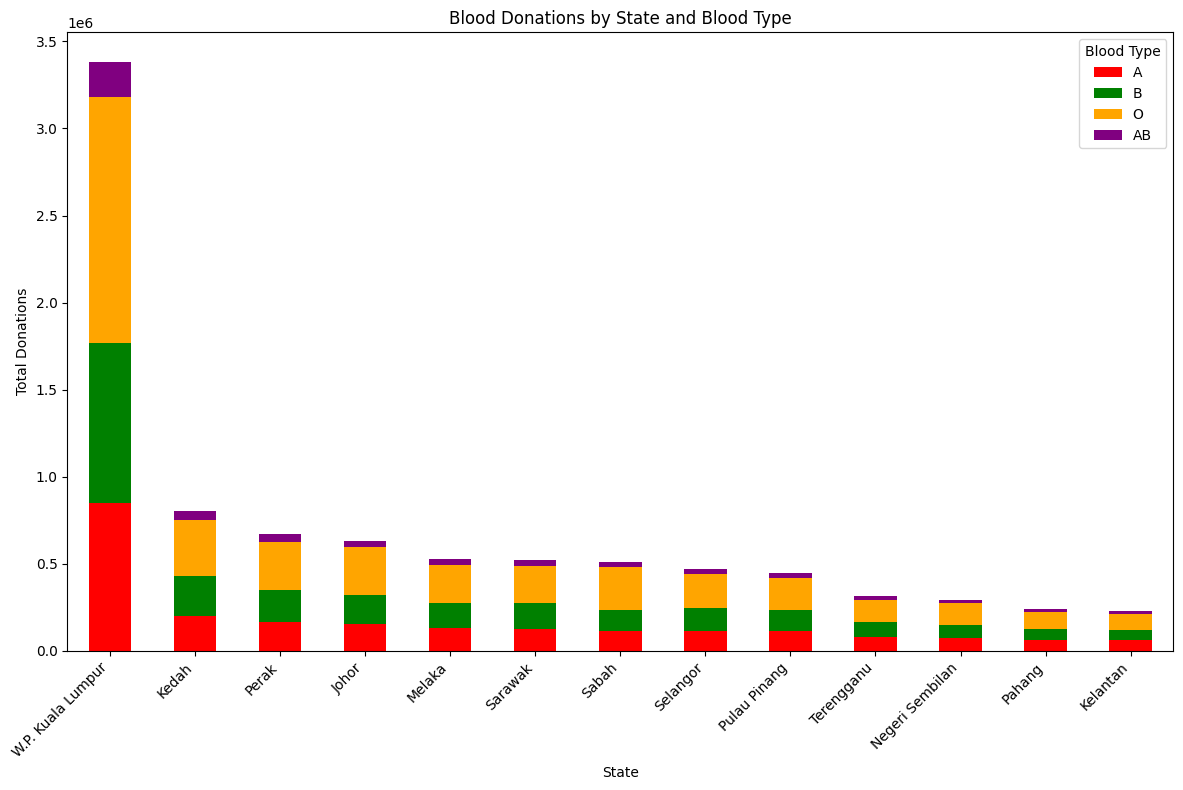

In [24]:
# Group data by state and sum donations for each blood type
grouped_state = df.group_by("state").agg([
    pl.col("a").sum().alias("A"),
    pl.col("b").sum().alias("B"),
    pl.col("o").sum().alias("O"),
    pl.col("ab").sum().alias("AB")
])

# Convert to pandas for easier plotting
grouped_state_pd = grouped_state.to_pandas()

# # Plot a stacked bar chart
# grouped_state_pd.set_index("state").plot(
#     kind="bar",
#     stacked=True,
#     figsize=(12, 8),
#     color=["red", "green", "orange", "purple"]
# )


# Add a column for total donations across all blood types
grouped_state_pd["Total"] = grouped_state_pd[["A", "B", "O", "AB"]].sum(axis=1)

# Sort the DataFrame by the total donations in descending order
grouped_state_pd = grouped_state_pd.sort_values(by="Total", ascending=False).drop(columns='Total')

# Plot a stacked bar chart
grouped_state_pd.set_index("state").plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
    color=["red", "green", "orange", "purple"]
)

plt.title("Blood Donations by State and Blood Type")
plt.xlabel("State")
plt.ylabel("Total Donations")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Blood Type")
plt.tight_layout()
plt.show()

# Investigating Data: Understanding Seasonality

In [25]:
# Getting a rolling mean for monthly smoothing
WINDOW_SIZE = 28

df_all = df_all.with_columns(
    pl.col("all").rolling_mean(WINDOW_SIZE).alias("trend_all"),
    pl.col("a").rolling_mean(WINDOW_SIZE).alias("trend_a"),
    pl.col("b").rolling_mean(WINDOW_SIZE).alias("trend_b"),
    pl.col("ab").rolling_mean(WINDOW_SIZE).alias("trend_ab"),
    pl.col("o").rolling_mean(WINDOW_SIZE).alias("trend_o"),
)

In [26]:
df_all = df_all.with_columns(
    (pl.col("all") - pl.col("trend_all")).alias("detrended_all"),
    (pl.col("a") - pl.col("trend_a")).alias("detrended_a"),
    (pl.col("b") - pl.col("trend_b")).alias("detrended_b"),
    (pl.col("ab") - pl.col("trend_ab")).alias("detrended_ab"),
    (pl.col("o") - pl.col("trend_o")).alias("detrended_o")
)

In [27]:
df_all = df_all.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

In [30]:
def group_dfs(df: pl.dataframe, group_col: str) -> pl.dataframe:
    
    return df.group_by(group_col).agg(
        pl.col("detrended_all").mean().alias("all_avg_seasonality"),
        pl.col("detrended_a").mean().alias("a_avg_seasonality"),
        pl.col("detrended_b").mean().alias("b_avg_seasonality"),
        pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
        pl.col("detrended_o").mean().alias("o_avg_seasonality")
    ).sort(group_col)
    
seasonality_by_dayofyear = group_dfs(df_all, 'day_of_year')
seasonality_by_weekday = group_dfs(df_all, 'weekday')
seasonality_by_month = group_dfs(df_all, 'month')
    


# seasonality_by_weekday = df_all.group_by("weekday").agg(
#     pl.col("detrended_all").mean().alias("all_avg_seasonality"),
#     pl.col("detrended_a").mean().alias("a_avg_seasonality"),
#     pl.col("detrended_b").mean().alias("b_avg_seasonality"),
#     pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
#     pl.col("detrended_o").mean().alias("o_avg_seasonality")
# ).sort("weekday")

# seasonality_by_month = df_all.group_by("month").agg(
#     pl.col("detrended_all").mean().alias("all_avg_seasonality"),
#     pl.col("detrended_a").mean().alias("a_avg_seasonality"),
#     pl.col("detrended_b").mean().alias("b_avg_seasonality"),
#     pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
#     pl.col("detrended_o").mean().alias("o_avg_seasonality")
# ).sort("month")

# seasonality_by_dayofyear = df_all.group_by("day_of_year").agg(
#     pl.col("detrended_all").mean().alias("all_avg_seasonality"),
#     pl.col("detrended_a").mean().alias("a_avg_seasonality"),
#     pl.col("detrended_b").mean().alias("b_avg_seasonality"),
#     pl.col("detrended_ab").mean().alias("ab_avg_seasonality"),
#     pl.col("detrended_o").mean().alias("o_avg_seasonality"),

# ).sort("day_of_year")

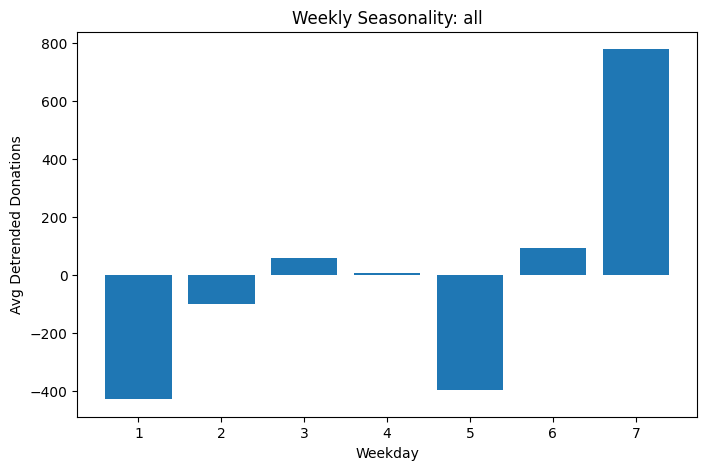

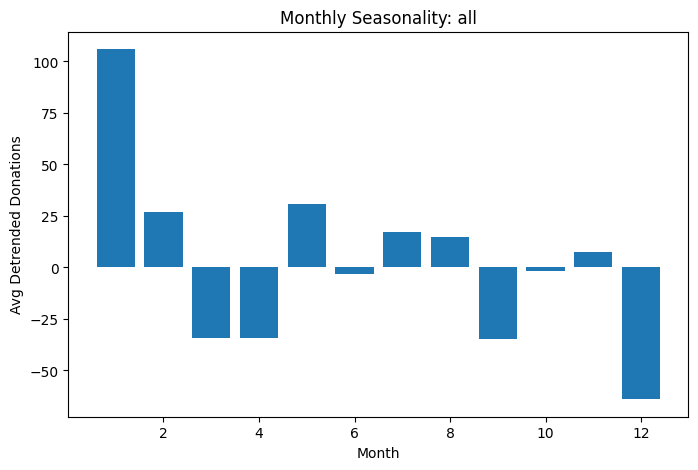

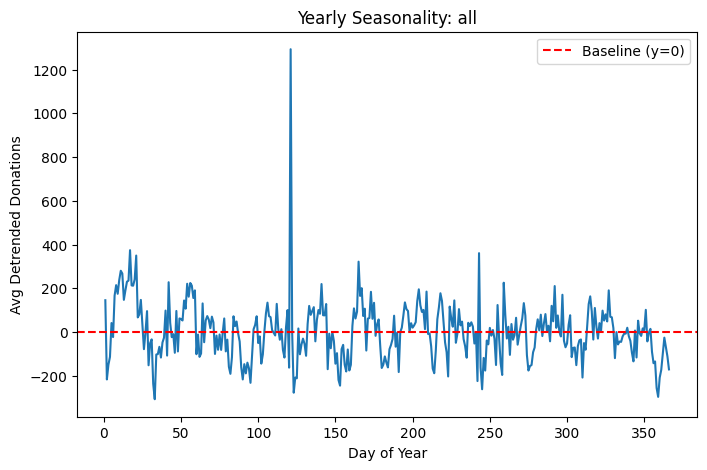

In [31]:
blood_type = 'all'


# Weekly seasonality
plt.figure(figsize=(8,5))
plt.bar(seasonality_by_weekday["weekday"].to_numpy(), seasonality_by_weekday[f"{blood_type}_avg_seasonality"].to_numpy())
plt.title(f"Weekly Seasonality: {blood_type}")
plt.xlabel("Weekday")
plt.ylabel("Avg Detrended Donations")
plt.show()

# Weekly seasonality
plt.figure(figsize=(8,5))
plt.bar(seasonality_by_month["month"].to_numpy(), seasonality_by_month[f"{blood_type}_avg_seasonality"].to_numpy())
plt.title(f"Monthly Seasonality: {blood_type}")
plt.xlabel("Month")
plt.ylabel("Avg Detrended Donations")
plt.show()

# Yearly seasonality
plt.figure(figsize=(8,5))
plt.plot(seasonality_by_dayofyear["day_of_year"].to_numpy(), seasonality_by_dayofyear[f"{blood_type}_avg_seasonality"].to_numpy())
plt.axhline(y=0, color='red', linestyle='--', label='Baseline (y=0)')
plt.title(f"Yearly Seasonality: {blood_type}")
plt.xlabel("Day of Year")
plt.ylabel("Avg Detrended Donations")
plt.legend()
plt.show()


In [57]:
# Analyze spike days
seasonality_by_dayofyear.sort("all_avg_seasonality", descending=True).head(5)

day_of_year,all_avg_seasonality,a_avg_seasonality,b_avg_seasonality,ab_avg_seasonality,o_avg_seasonality
i16,f64,f64,f64,f64,f64
121,1256.174812,340.723684,305.87594,74.191729,535.383459
17,374.146617,88.526316,108.238722,23.37406,154.007519
243,360.528195,93.37782,81.890977,21.921053,163.338346
21,349.473684,76.701128,103.368421,21.191729,148.212406
165,321.56015,81.293233,91.486842,18.466165,130.31391


Very interesting to see this. 121st day of the year leads to by far the biggest spike. The explanation is relatively straightforward. Day number 121 is 1st of May, a public holiday. Given that people are not working on that day, they have capacity for donating blood. Also, for number 3, day 243 is August 31, Hari Merdeka (Independence Day) in Malaysia, which also gives people time to donate blood. 

In [31]:
df_all.select("date", "all").sort("all", descending=True).head(10)

date,all
date,i64
2012-09-11,5543
2019-05-01,4684
2019-08-25,4516
2015-08-12,4359
2018-08-19,4283
2018-05-01,4193
2019-08-24,4188
2024-05-01,4047
2024-04-21,3996


In [61]:
# Analyze spike days
seasonality_by_dayofyear.sort("all_avg_seasonality", descending=False).head(5)

day_of_year,all_avg_seasonality,a_avg_seasonality,b_avg_seasonality,ab_avg_seasonality,o_avg_seasonality
i16,f64,f64,f64,f64,f64
33,-307.846429,-69.464286,-91.401786,-19.7875,-127.192857
123,-306.951128,-75.915414,-80.056391,-19.131579,-131.847744
359,-297.048872,-69.340226,-84.87782,-19.280075,-123.550752
245,-262.257519,-66.071429,-73.426692,-16.697368,-106.06203
358,-256.291353,-66.156015,-70.695489,-15.148496,-104.291353


In [60]:
df_all.select("date", "all").sort("all", descending=False).head(10)

date,all
date,i64
2006-01-29,0
2013-05-05,0
2018-06-15,0
2021-05-13,0
2024-04-10,0
2025-03-31,0
2010-09-10,1
2006-01-10,2
2007-12-20,3
